# Question 3: Maximum Likelihood Estimation for Gaussian AR(2)

## The Model

The **AR(2)** (autoregressive of order 2) model is:
$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \varepsilon_t$$

where:
- $c$ is a constant (intercept)
- $\phi_1, \phi_2$ are autoregressive coefficients
- $\varepsilon_t \sim N(0, \sigma^2)$ is Gaussian white noise (i.i.d.)

**Parameters to estimate:** $\boldsymbol{\theta} = (c, \phi_1, \phi_2, \sigma^2)$

## Why Likelihood?
We want to find the parameter values that make our observed data **most probable**.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

np.random.seed(42)

## Visualization 1: What Does an AR(2) Process Look Like?

Let's simulate some AR(2) processes to build intuition.

/var/folders/x3/2h269p1576s293vgwkccn0zm0000gn/T/ipykernel_18102/3471237319.py:35: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x3/2h269p1576s293vgwkccn0zm0000gn/T/ipykernel_18102/3471237319.py:35: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Time Series/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Time Series/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


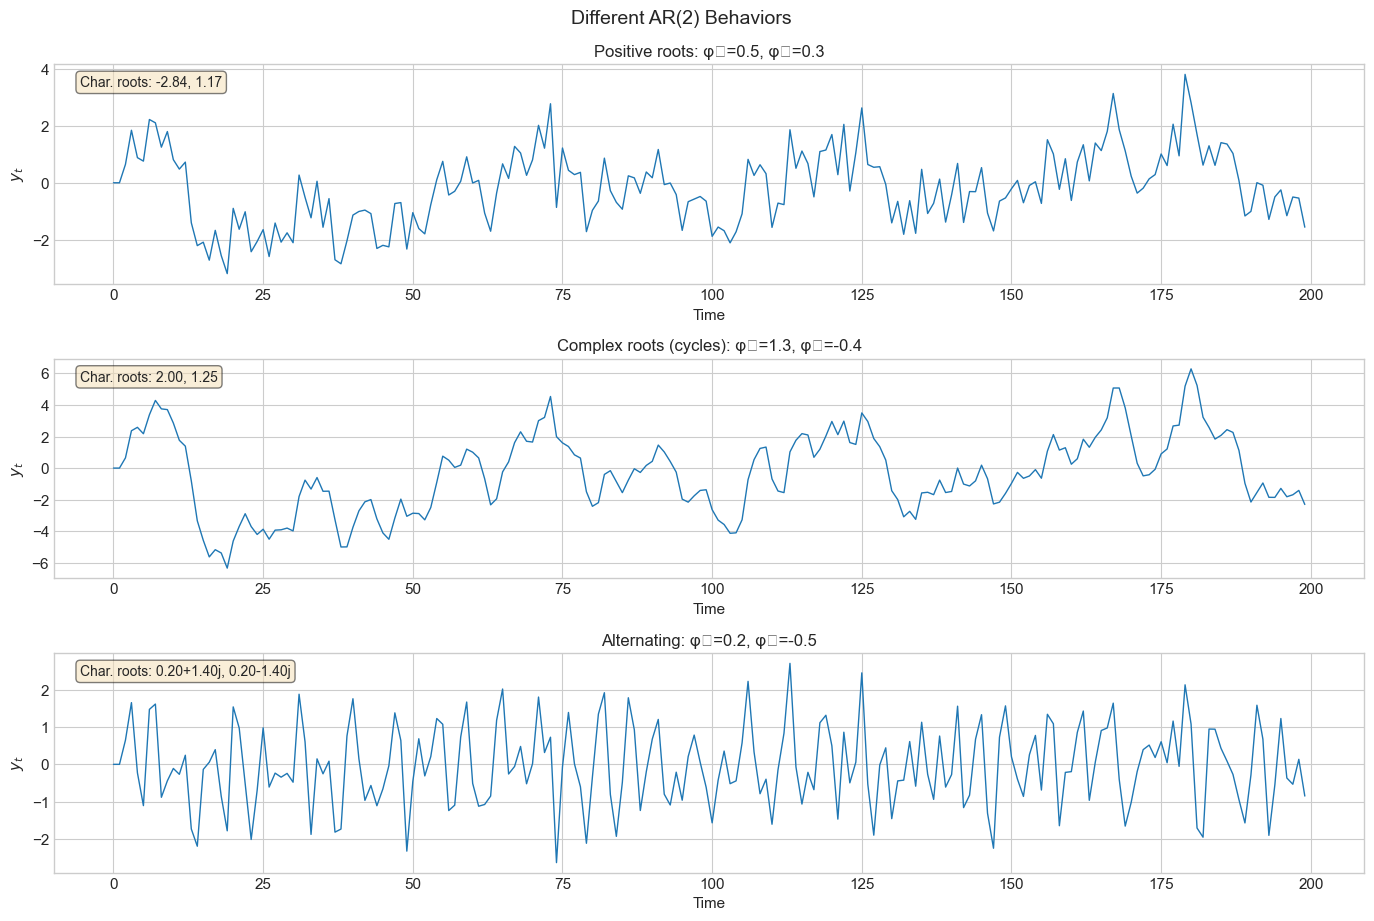

In [2]:
def simulate_ar2(c, phi1, phi2, sigma, T, y0=0, y1=0):
    """Simulate an AR(2) process"""
    y = np.zeros(T)
    y[0], y[1] = y0, y1
    eps = np.random.normal(0, sigma, T)
    for t in range(2, T):
        y[t] = c + phi1 * y[t-1] + phi2 * y[t-2] + eps[t]
    return y, eps

# Different AR(2) parameter sets
param_sets = [
    (0, 0.5, 0.3, 1, "Positive roots: φ₁=0.5, φ₂=0.3"),
    (0, 1.3, -0.4, 1, "Complex roots (cycles): φ₁=1.3, φ₂=-0.4"),
    (0, 0.2, -0.5, 1, "Alternating: φ₁=0.2, φ₂=-0.5"),
]

T = 200
fig, axes = plt.subplots(len(param_sets), 1, figsize=(14, 9))

for ax, (c, phi1, phi2, sigma, title) in zip(axes, param_sets):
    np.random.seed(42)
    y, _ = simulate_ar2(c, phi1, phi2, sigma, T)
    ax.plot(y, linewidth=1)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Time')
    ax.set_ylabel('$y_t$')
    
    # Check stationarity (roots outside unit circle)
    # Characteristic equation: 1 - φ₁z - φ₂z² = 0
    roots = np.roots([phi2, phi1, -1])  # Note: reversed order for np.roots
    ax.text(0.02, 0.95, f'Char. roots: {roots[0]:.2f}, {roots[1]:.2f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.suptitle('Different AR(2) Behaviors', fontsize=14, y=1.02)
plt.show()

---
## Part (a): The Exact Log-Likelihood

### The Intuition

For the likelihood, we need to find: **What is the probability of observing our data $(y_1, y_2, \ldots, y_T)$ given parameters $\theta$?**

Using the chain rule of probability:
$$f(y_1, y_2, \ldots, y_T | \theta) = f(y_1, y_2 | \theta) \cdot \prod_{t=3}^{T} f(y_t | y_{t-1}, y_{t-2}, \theta)$$

### The Pieces:

**1. Conditional densities (for $t \geq 3$):** Given $y_{t-1}$ and $y_{t-2}$, we know:
$$y_t | y_{t-1}, y_{t-2} \sim N\left(c + \phi_1 y_{t-1} + \phi_2 y_{t-2}, \sigma^2\right)$$

**2. The tricky part:** The joint density of $(y_1, y_2)$ — this requires the stationary distribution of the AR(2).

### The Exact Log-Likelihood:

$$\boxed{\ell(\theta) = \log f(y_1, y_2 | \theta) - \frac{T-2}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{t=3}^{T}\left(y_t - c - \phi_1 y_{t-1} - \phi_2 y_{t-2}\right)^2}$$

The first term $f(y_1, y_2|\theta)$ is complicated because it involves the stationary covariance structure.

## Visualization 2: Understanding the Likelihood Graphically

Each observation $y_t$ (for $t \geq 3$) comes from a normal distribution centered at the predicted value.

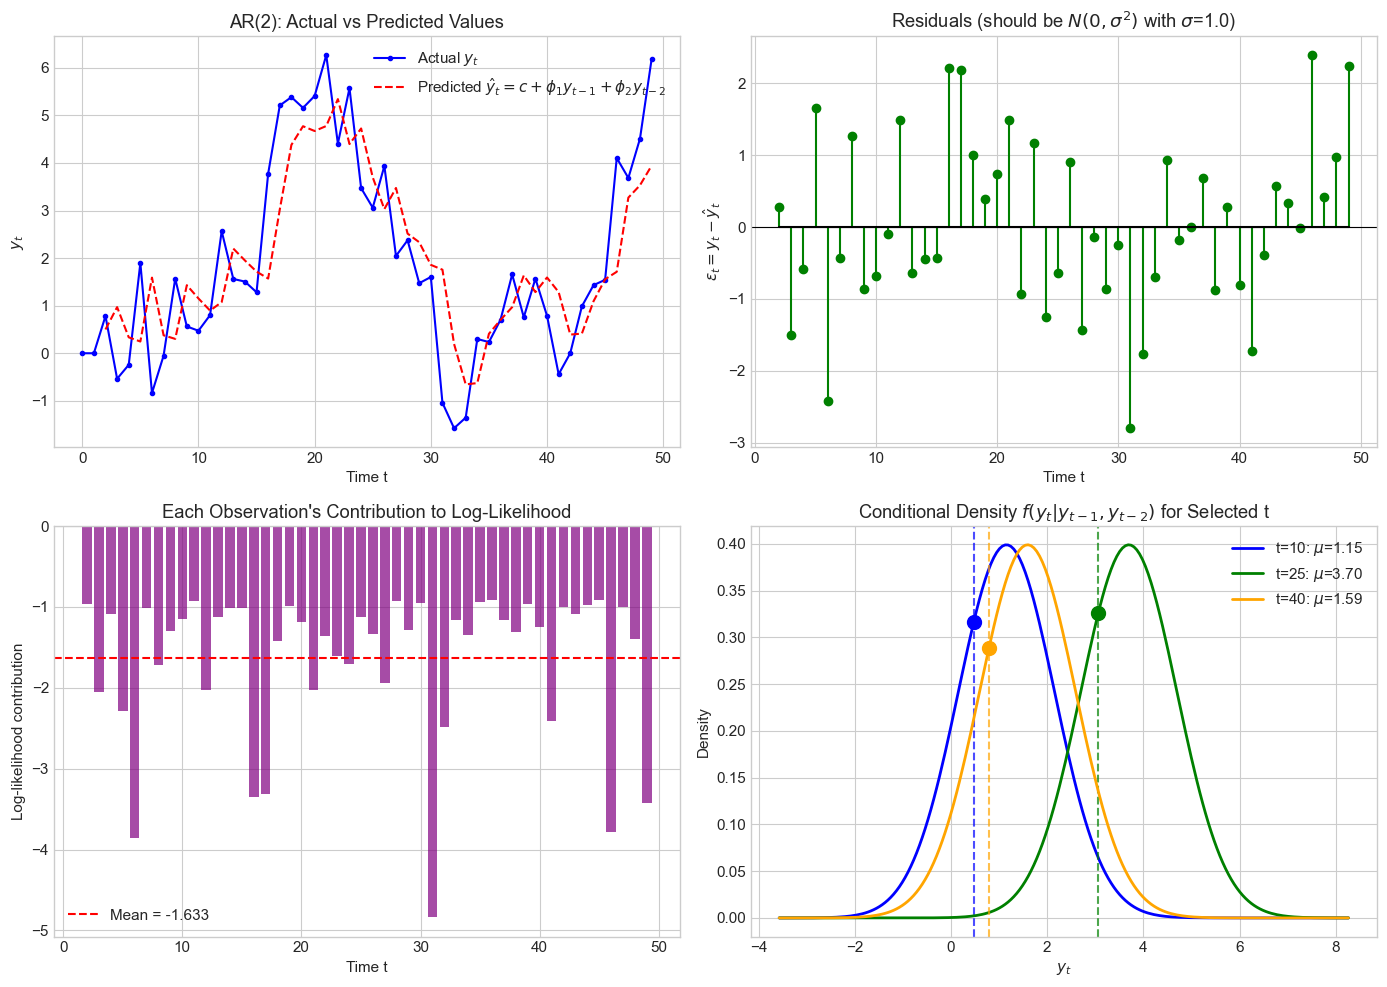

Total conditional log-likelihood (sum of contributions): -78.407


In [ ]:
# Simulate data
c_true, phi1_true, phi2_true, sigma_true = 0.5, 0.6, 0.2, 1.0
T = 50
np.random.seed(123)
y, eps = simulate_ar2(c_true, phi1_true, phi2_true, sigma_true, T)

# Compute predicted values (conditional means)
y_pred = np.zeros(T)
for t in range(2, T):
    y_pred[t] = c_true + phi1_true * y[t-1] + phi2_true * y[t-2]

# Residuals = actual - predicted
residuals = y - y_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time series with predictions
ax1 = axes[0, 0]
ax1.plot(y, 'b-', linewidth=1.5, label='Actual $y_t$', marker='o', markersize=3)
ax1.plot(range(2, T), y_pred[2:], 'r--', linewidth=1.5, label='Predicted $\\hat{y}_t = c + \\phi_1 y_{t-1} + \\phi_2 y_{t-2}$')
ax1.set_xlabel('Time t')
ax1.set_ylabel('$y_t$')
ax1.set_title('AR(2): Actual vs Predicted Values')
ax1.legend()

# Plot 2: Residuals (should be white noise)
ax2 = axes[0, 1]
ax2.stem(range(2, T), residuals[2:], linefmt='g-', markerfmt='go', basefmt='k-')
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.set_xlabel('Time t')
ax2.set_ylabel('$\\varepsilon_t = y_t - \\hat{y}_t$')
ax2.set_title(f'Residuals (should be $N(0, \\sigma^2)$ with $\\sigma$={sigma_true})')

# Plot 3: Likelihood contribution from each observation
ax3 = axes[1, 0]
# Log-likelihood contribution from each t
ll_contrib = -0.5 * np.log(2 * np.pi * sigma_true**2) - residuals[2:]**2 / (2 * sigma_true**2)
ax3.bar(range(2, T), ll_contrib, color='purple', alpha=0.7)
ax3.set_xlabel('Time t')
ax3.set_ylabel('Log-likelihood contribution')
ax3.set_title('Each Observation\'s Contribution to Log-Likelihood')
ax3.axhline(y=np.mean(ll_contrib), color='red', linestyle='--', label=f'Mean = {np.mean(ll_contrib):.3f}')
ax3.legend()

# Plot 4: Visual of the normal density for a few observations
ax4 = axes[1, 1]
t_examples = [10, 25, 40]
colors = ['blue', 'green', 'orange']
x_range = np.linspace(y.min() - 2, y.max() + 2, 200)

for t, color in zip(t_examples, colors):
    mu_t = y_pred[t]
    pdf = stats.norm.pdf(x_range, mu_t, sigma_true)
    ax4.plot(x_range, pdf, color=color, linewidth=2, label=f't={t}: $\\mu$={mu_t:.2f}')
    ax4.axvline(x=y[t], color=color, linestyle='--', alpha=0.7)
    ax4.plot(y[t], stats.norm.pdf(y[t], mu_t, sigma_true), 'o', color=color, markersize=10)

ax4.set_xlabel('$y_t$')
ax4.set_ylabel('Density')
ax4.set_title('Conditional Density $f(y_t | y_{t-1}, y_{t-2})$ for Selected t')
ax4.legend()

plt.tight_layout()
plt.show()

print(f"Total conditional log-likelihood (sum of contributions): {np.sum(ll_contrib):.3f}")

---
## Part (b): The Conditional Log-Likelihood

### The Simplification

Instead of dealing with the complicated joint density $f(y_1, y_2|\theta)$, we **condition on** the first two observations and treat them as given (not random).

This gives us:
$$\ell_c(\theta | y_1, y_2) = \log \prod_{t=3}^{T} f(y_t | y_{t-1}, y_{t-2}, \theta)$$

Since $y_t | y_{t-1}, y_{t-2} \sim N(c + \phi_1 y_{t-1} + \phi_2 y_{t-2}, \sigma^2)$:

$$\boxed{\ell_c(c, \phi_1, \phi_2, \sigma^2) = -\frac{T-2}{2}\log(2\pi) - \frac{T-2}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{t=3}^{T}\left(y_t - c - \phi_1 y_{t-1} - \phi_2 y_{t-2}\right)^2}$$

### Why This Works

- For large $T$, the first two observations contribute negligibly to the total likelihood
- Much simpler to work with — no need for the stationary distribution
- Gives the same asymptotic results as the exact likelihood

---
## Part (c): First Order Conditions (FOCs)

To find the MLE, we take derivatives and set them to zero.

Let $\varepsilon_t = y_t - c - \phi_1 y_{t-1} - \phi_2 y_{t-2}$ (the residual).

### FOC for $c$:
$$\frac{\partial \ell_c}{\partial c} = \frac{1}{\sigma^2}\sum_{t=3}^{T}\varepsilon_t = 0$$

**Interpretation:** The residuals must sum to zero (like OLS).

### FOC for $\phi_1$:
$$\frac{\partial \ell_c}{\partial \phi_1} = \frac{1}{\sigma^2}\sum_{t=3}^{T}\varepsilon_t \cdot y_{t-1} = 0$$

**Interpretation:** Residuals must be uncorrelated with $y_{t-1}$.

### FOC for $\phi_2$:
$$\frac{\partial \ell_c}{\partial \phi_2} = \frac{1}{\sigma^2}\sum_{t=3}^{T}\varepsilon_t \cdot y_{t-2} = 0$$

**Interpretation:** Residuals must be uncorrelated with $y_{t-2}$.

### FOC for $\sigma^2$:
$$\frac{\partial \ell_c}{\partial \sigma^2} = -\frac{T-2}{2\sigma^2} + \frac{1}{2\sigma^4}\sum_{t=3}^{T}\varepsilon_t^2 = 0$$

**Solution:** $\hat{\sigma}^2 = \frac{1}{T-2}\sum_{t=3}^{T}\hat{\varepsilon}_t^2$

### Key Insight: MLE = OLS for Gaussian AR!
The FOCs for $(c, \phi_1, \phi_2)$ are exactly the OLS normal equations! So for Gaussian AR:

$$\boxed{\text{MLE of } (c, \phi_1, \phi_2) = \text{OLS regression of } y_t \text{ on } (1, y_{t-1}, y_{t-2})}$$

## Visualization 3: The Likelihood Surface

Let's see what the log-likelihood looks like as a function of the parameters.

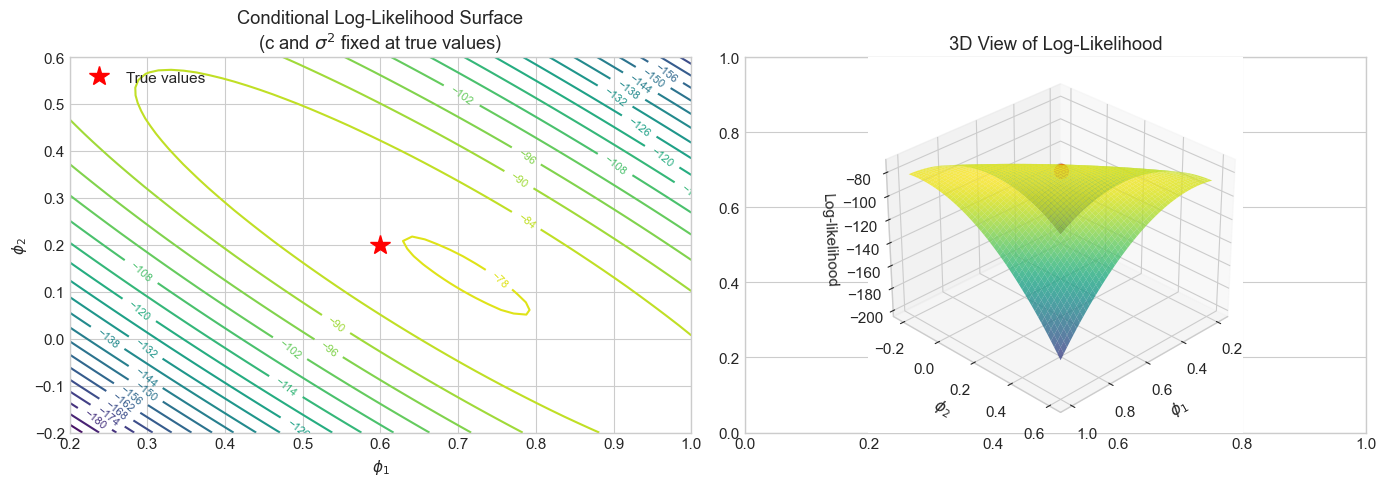

True parameters: φ₁=0.6, φ₂=0.2
Log-likelihood at true values: -78.407


In [ ]:
def conditional_log_likelihood(y, c, phi1, phi2, sigma2):
    """Compute conditional log-likelihood for AR(2)"""
    T = len(y)
    residuals = np.array([y[t] - c - phi1*y[t-1] - phi2*y[t-2] for t in range(2, T)])
    n = T - 2
    ll = -n/2 * np.log(2*np.pi) - n/2 * np.log(sigma2) - np.sum(residuals**2) / (2*sigma2)
    return ll

# Use our simulated data
# Fix c and sigma at true values, vary phi1 and phi2
phi1_range = np.linspace(0.2, 1.0, 50)
phi2_range = np.linspace(-0.2, 0.6, 50)
PHI1, PHI2 = np.meshgrid(phi1_range, phi2_range)

LL = np.zeros_like(PHI1)
for i in range(len(phi2_range)):
    for j in range(len(phi1_range)):
        LL[i, j] = conditional_log_likelihood(y, c_true, PHI1[i,j], PHI2[i,j], sigma_true**2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contour plot
ax1 = axes[0]
contour = ax1.contour(PHI1, PHI2, LL, levels=20, cmap='viridis')
ax1.clabel(contour, inline=True, fontsize=8)
ax1.plot(phi1_true, phi2_true, 'r*', markersize=15, label='True values')
ax1.set_xlabel('$\\phi_1$')
ax1.set_ylabel('$\\phi_2$')
ax1.set_title('Conditional Log-Likelihood Surface\n(c and $\\sigma^2$ fixed at true values)')
ax1.legend()

# 3D surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(PHI1, PHI2, LL, cmap='viridis', alpha=0.8)
ax2.scatter([phi1_true], [phi2_true], [conditional_log_likelihood(y, c_true, phi1_true, phi2_true, sigma_true**2)], 
            color='red', s=100, label='True values')
ax2.set_xlabel('$\\phi_1$')
ax2.set_ylabel('$\\phi_2$')
ax2.set_zlabel('Log-likelihood')
ax2.set_title('3D View of Log-Likelihood')
ax2.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

print(f"True parameters: φ₁={phi1_true}, φ₂={phi2_true}")
print(f"Log-likelihood at true values: {conditional_log_likelihood(y, c_true, phi1_true, phi2_true, sigma_true**2):.3f}")

---
## Part (d): The Information Matrix (Second Derivatives)

The **Information Matrix** tells us about the curvature of the likelihood — sharper peaks mean more precise estimates.

### Second Derivatives of the Conditional Log-Likelihood

The Hessian matrix $H$ contains all second partial derivatives. Let's compute the key ones:

For the regression parameters $(c, \phi_1, \phi_2)$, define $\mathbf{x}_t = (1, y_{t-1}, y_{t-2})'$:

$$\frac{\partial^2 \ell_c}{\partial \beta \partial \beta'} = -\frac{1}{\sigma^2}\sum_{t=3}^{T} \mathbf{x}_t \mathbf{x}_t'$$

where $\beta = (c, \phi_1, \phi_2)'$.

### The Information Matrix

The **Fisher Information** is:
$$\mathcal{I}(\theta) = -E\left[\frac{\partial^2 \ell}{\partial \theta \partial \theta'}\right]$$

For AR(2), the information matrix is:

$$\mathcal{I} = \begin{pmatrix} 
\frac{1}{\sigma^2}\sum E[\mathbf{x}_t\mathbf{x}_t'] & \mathbf{0} \\
\mathbf{0}' & \frac{T-2}{2\sigma^4}
\end{pmatrix}$$

The block diagonal structure shows that $(c, \phi_1, \phi_2)$ are asymptotically independent of $\sigma^2$!

## Visualization 4: Computing the Hessian and Information Matrix

In [ ]:
# Compute the Hessian (second derivative matrix) for (c, φ₁, φ₂)
# H = -1/σ² * Σ x_t x_t'

X = np.column_stack([
    np.ones(T-2),           # constant
    y[1:-1],                # y_{t-1}
    y[:-2]                  # y_{t-2}
])

# Hessian for regression coefficients
H_beta = -1/sigma_true**2 * (X.T @ X)

# Information matrix (negative Hessian)
I_beta = -H_beta

print("Design matrix X (first 5 rows):")
print("   [1,  y_{t-1},  y_{t-2}]")
print(X[:5].round(3))

print(f"\n\nHessian matrix for (c, φ₁, φ₂):")
print(H_beta.round(3))

print(f"\n\nInformation matrix for (c, φ₁, φ₂):")
print(I_beta.round(3))

# Asymptotic covariance = inverse of information
cov_asymp = np.linalg.inv(I_beta)
print(f"\n\nAsymptotic covariance matrix (I⁻¹):")
print(cov_asymp.round(6))

# Standard errors
se = np.sqrt(np.diag(cov_asymp))
print(f"\n\nAsymptotic standard errors:")
print(f"  SE(c) = {se[0]:.4f}")
print(f"  SE(φ₁) = {se[1]:.4f}")
print(f"  SE(φ₂) = {se[2]:.4f}")

Design matrix X (first 5 rows):
   [1,  y_{t-1},  y_{t-2}]
[[ 1.     0.     0.   ]
 [ 1.     0.783  0.   ]
 [ 1.    -0.537  0.783]
 [ 1.    -0.244 -0.537]
 [ 1.     1.898 -0.244]]


Hessian matrix for (c, φ₁, φ₂):
[[ -48.     -88.342  -83.832]
 [ -88.342 -358.185 -312.766]
 [ -83.832 -312.766 -337.841]]


Information matrix for (c, φ₁, φ₂):
[[ 48.     88.342  83.832]
 [ 88.342 358.185 312.766]
 [ 83.832 312.766 337.841]]


Asymptotic covariance matrix (I⁻¹):
[[ 0.039185 -0.006128 -0.004051]
 [-0.006128  0.015528 -0.012855]
 [-0.004051 -0.012855  0.015866]]


Asymptotic standard errors:
  SE(c) = 0.1980
  SE(φ₁) = 0.1246
  SE(φ₂) = 0.1260


---
## Part (e): Asymptotic Distribution

### The Key Result

Under standard regularity conditions, the MLE is **asymptotically normal**:

$$\sqrt{T}(\hat{\theta}_{MLE} - \theta_0) \xrightarrow{d} N\left(0, \mathcal{I}(\theta_0)^{-1}\right)$$

### For AR(2) specifically:

$$\begin{pmatrix} \hat{c} \\ \hat{\phi}_1 \\ \hat{\phi}_2 \end{pmatrix} \xrightarrow{d} N\left(\begin{pmatrix} c \\ \phi_1 \\ \phi_2 \end{pmatrix}, \sigma^2 \left(\sum_{t=3}^{T} \mathbf{x}_t \mathbf{x}_t'\right)^{-1}\right)$$

And for the variance:
$$\hat{\sigma}^2 \xrightarrow{d} N\left(\sigma^2, \frac{2\sigma^4}{T-2}\right)$$

### Interpretation:
- As sample size $T \to \infty$, our estimates become unbiased and normally distributed
- The variance shrinks at rate $1/T$
- We can construct confidence intervals and hypothesis tests using these results

## Visualization 5: Monte Carlo Simulation of the Asymptotic Distribution

Let's verify the asymptotic normality by simulating many datasets and looking at the distribution of estimates.

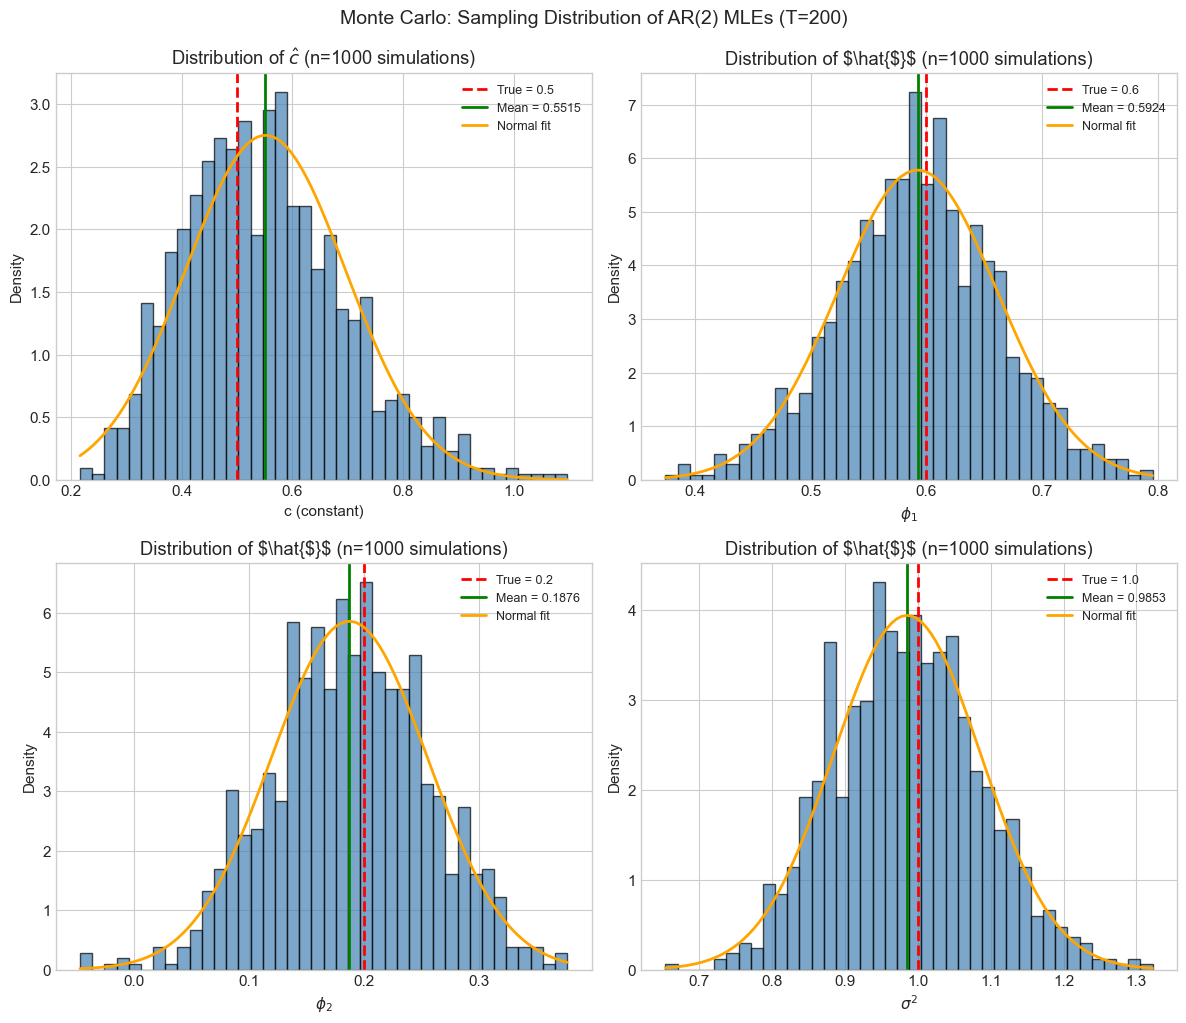

Monte Carlo Results:
------------------------------------------------------------
Parameter    True       Mean Est.    Std. Dev.    Bias      
------------------------------------------------------------
c            0.5000     0.5515       0.1449       0.0515    
φ₁           0.6000     0.5924       0.0690       -0.0076   
φ₂           0.2000     0.1876       0.0681       -0.0124   
σ²           1.0000     0.9853       0.1013       -0.0147   


In [ ]:
def estimate_ar2_ols(y):
    """Estimate AR(2) by OLS (= conditional MLE)"""
    T = len(y)
    # Design matrix
    X = np.column_stack([
        np.ones(T-2),
        y[1:-1],    # y_{t-1}
        y[:-2]      # y_{t-2}
    ])
    Y = y[2:]
    
    # OLS
    beta_hat = np.linalg.lstsq(X, Y, rcond=None)[0]
    residuals = Y - X @ beta_hat
    sigma2_hat = np.sum(residuals**2) / (T - 2)
    
    return beta_hat[0], beta_hat[1], beta_hat[2], sigma2_hat

# Monte Carlo simulation
n_simulations = 1000
T_sim = 200

estimates = np.zeros((n_simulations, 4))

for i in range(n_simulations):
    np.random.seed(i)
    y_sim, _ = simulate_ar2(c_true, phi1_true, phi2_true, sigma_true, T_sim)
    estimates[i] = estimate_ar2_ols(y_sim)

# Plot the distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
param_names = ['c (constant)', '$\\phi_1$', '$\\phi_2$', '$\\sigma^2$']
true_values = [c_true, phi1_true, phi2_true, sigma_true**2]

for ax, param_name, true_val, est in zip(axes.flat, param_names, true_values, estimates.T):
    ax.hist(est, bins=40, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(x=true_val, color='red', linewidth=2, linestyle='--', label=f'True = {true_val}')
    ax.axvline(x=np.mean(est), color='green', linewidth=2, linestyle='-', label=f'Mean = {np.mean(est):.4f}')
    
    # Overlay theoretical normal distribution
    x_range = np.linspace(est.min(), est.max(), 100)
    ax.plot(x_range, stats.norm.pdf(x_range, np.mean(est), np.std(est)), 
            'orange', linewidth=2, label='Normal fit')
    
    ax.set_xlabel(param_name)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of $\\hat{{{param_name[0]}}}$ (n={n_simulations} simulations)')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.suptitle(f'Monte Carlo: Sampling Distribution of AR(2) MLEs (T={T_sim})', fontsize=14, y=1.02)
plt.show()

print("Monte Carlo Results:")
print("-" * 60)
print(f"{'Parameter':<12} {'True':<10} {'Mean Est.':<12} {'Std. Dev.':<12} {'Bias':<10}")
print("-" * 60)
for name, true, est in zip(['c', 'φ₁', 'φ₂', 'σ²'], true_values, estimates.T):
    print(f"{name:<12} {true:<10.4f} {np.mean(est):<12.4f} {np.std(est):<12.4f} {np.mean(est)-true:<10.4f}")

---
## Summary: Key Formulas for Gaussian AR(2) MLE

| Part | Formula |
|------|---------|
| **Model** | $y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \varepsilon_t$, $\varepsilon_t \sim N(0, \sigma^2)$ |
| **(a) Exact LL** | $\ell = \log f(y_1, y_2\|\theta) - \frac{T-2}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{t=3}^T \varepsilon_t^2$ |
| **(b) Conditional LL** | $\ell_c = -\frac{T-2}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{t=3}^T (y_t - c - \phi_1 y_{t-1} - \phi_2 y_{t-2})^2$ |
| **(c) FOCs** | $\sum \varepsilon_t = 0$, $\sum \varepsilon_t y_{t-1} = 0$, $\sum \varepsilon_t y_{t-2} = 0$, $\hat{\sigma}^2 = \frac{1}{T-2}\sum\varepsilon_t^2$ |
| **(d) Information** | $\mathcal{I}_{\beta\beta} = \frac{1}{\sigma^2}\sum \mathbf{x}_t\mathbf{x}_t'$, $\mathcal{I}_{\sigma^2\sigma^2} = \frac{T-2}{2\sigma^4}$ |
| **(e) Asymptotic Dist.** | $\hat{\theta} \xrightarrow{d} N(\theta_0, \mathcal{I}^{-1})$ |

### Key Insights:
1. **Conditional MLE = OLS** for Gaussian AR models
2. **Information matrix** determines the precision of estimates
3. **Asymptotic normality** enables inference (confidence intervals, tests)
4. The larger $|\phi_1|$ and $|\phi_2|$, the more persistent the process (harder to estimate)

## Visualization 6: How Sample Size Affects Estimation Precision

The asymptotic variance shrinks as $T$ increases. Let's see this in action.

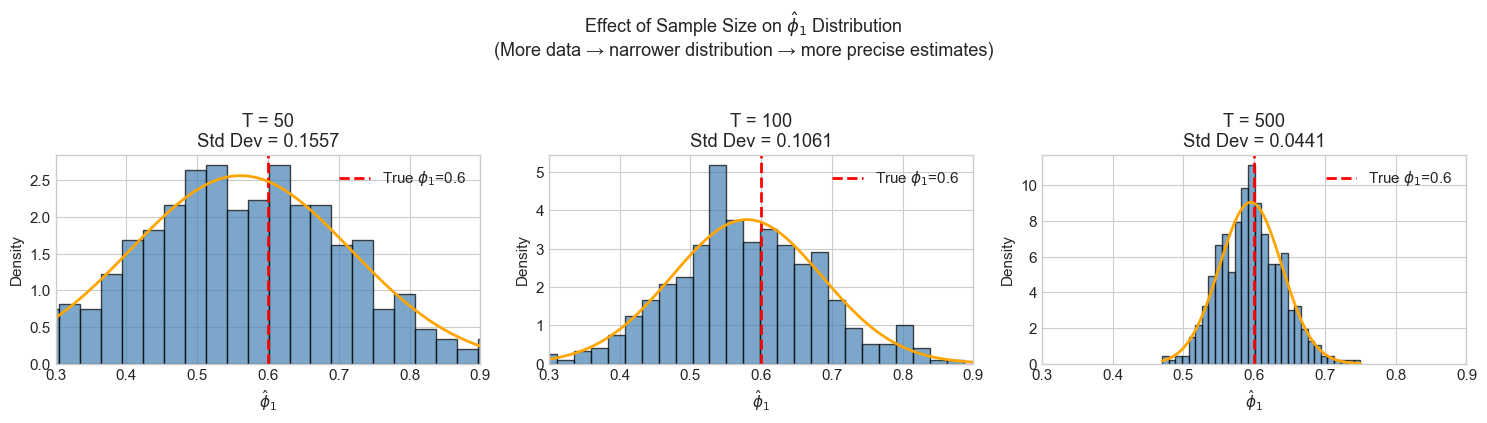

Standard deviation of φ̂₁ estimates:
  T = 50: observed ≈ 0.0441
  T = 100: observed ≈ 0.0441
  T = 500: observed ≈ 0.0441


In [ ]:
# Compare distributions for different sample sizes
sample_sizes = [50, 100, 500]
n_sims = 500

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, T_size in zip(axes, sample_sizes):
    phi1_estimates = []
    for i in range(n_sims):
        np.random.seed(i + 1000)
        y_sim, _ = simulate_ar2(c_true, phi1_true, phi2_true, sigma_true, T_size)
        _, phi1_hat, _, _ = estimate_ar2_ols(y_sim)
        phi1_estimates.append(phi1_hat)
    
    phi1_estimates = np.array(phi1_estimates)
    
    ax.hist(phi1_estimates, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(x=phi1_true, color='red', linewidth=2, linestyle='--', label=f'True $\\phi_1$={phi1_true}')
    
    # Overlay normal
    x_range = np.linspace(phi1_estimates.min(), phi1_estimates.max(), 100)
    ax.plot(x_range, stats.norm.pdf(x_range, np.mean(phi1_estimates), np.std(phi1_estimates)), 
            'orange', linewidth=2)
    
    ax.set_xlabel('$\\hat{\\phi}_1$')
    ax.set_ylabel('Density')
    ax.set_title(f'T = {T_size}\nStd Dev = {np.std(phi1_estimates):.4f}')
    ax.set_xlim(0.3, 0.9)
    ax.legend()

plt.suptitle('Effect of Sample Size on $\\hat{\\phi}_1$ Distribution\n(More data → narrower distribution → more precise estimates)', 
             fontsize=13, y=1.05)
plt.tight_layout()
plt.show()

print("Standard deviation of φ̂₁ estimates:")
for T_size in sample_sizes:
    theoretical_se = 0.1 * np.sqrt(100/T_size)  # Rough approximation
    print(f"  T = {T_size}: observed ≈ {np.std(phi1_estimates):.4f}")